In [1]:
import pandas as pd
from dp_transformer import DifferentialPrivacyTransformer

In [21]:
df = pd.read_csv('../Titanic/bases/titanic_data_clean.csv')
q_vars = ['Fare']
c_vars = ['Pclass', 'Sex', 'Embarked']

In [22]:
dp_tr = DifferentialPrivacyTransformer(df, epsilon = 1, quantitative_vars=q_vars, categorical_vars=c_vars)
dp_tr

In [23]:
dp_tr.fit_quantitative()
dp_tr.fit_categorical()

In [24]:
dp_tr.df_transformed

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,2,1,1,0,-298.163694,0
1,1,2,0,1,0,-298.163694,0
2,1,3,1,0,0,-298.163694,2
3,1,1,0,1,0,-298.163694,3
4,0,1,0,0,0,-298.163694,2
...,...,...,...,...,...,...,...
886,0,3,1,0,0,810.492894,0
887,1,1,0,0,0,810.492894,2
888,0,3,0,1,2,810.492894,2
889,1,3,0,0,0,-298.163694,0


In [25]:
dp_tr.df

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,1,1,0,7.2500,2
1,1,1,0,1,0,71.2833,0
2,1,3,0,0,0,7.9250,2
3,1,1,0,1,0,53.1000,2
4,0,3,1,0,0,8.0500,2
...,...,...,...,...,...,...,...
886,0,2,1,0,0,13.0000,2
887,1,1,0,0,0,30.0000,2
888,0,3,0,1,2,23.4500,2
889,1,1,1,0,0,30.0000,0


In [6]:
dp_tr.df_transformed

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Fare_priv,Survived_priv,Pclass_priv,Sex_priv,SibSp_priv,Parch_priv,Embarked_priv
0,0,3,1,1,0,7.2500,2,-298.163694,0,2,1,5,4,0
1,1,1,0,1,0,71.2833,0,-298.163694,0,1,0,3,0,0
2,1,3,0,0,0,7.9250,2,-298.163694,1,3,1,5,6,1
3,1,1,0,1,0,53.1000,2,-298.163694,1,3,0,0,5,0
4,0,3,1,0,0,8.0500,2,-298.163694,0,1,0,0,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,0,13.0000,2,-298.163694,0,3,1,2,0,2
887,1,1,0,0,0,30.0000,2,-298.163694,0,2,0,5,5,0
888,0,3,0,1,2,23.4500,2,-298.163694,0,2,0,1,2,2
889,1,1,1,0,0,30.0000,0,-298.163694,1,2,0,2,0,3


In [10]:
dp_tr.df
dp_tr.df_transformed

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,-298.163694,2
1,0,1,0,5,3,-298.163694,3
2,0,1,0,8,4,-298.163694,0
3,1,3,0,2,0,-298.163694,2
4,0,2,0,3,3,810.492894,1
...,...,...,...,...,...,...,...
886,1,2,1,0,2,-298.163694,2
887,0,1,0,0,4,-298.163694,0
888,0,3,0,4,2,810.492894,2
889,0,2,1,0,6,-298.163694,0


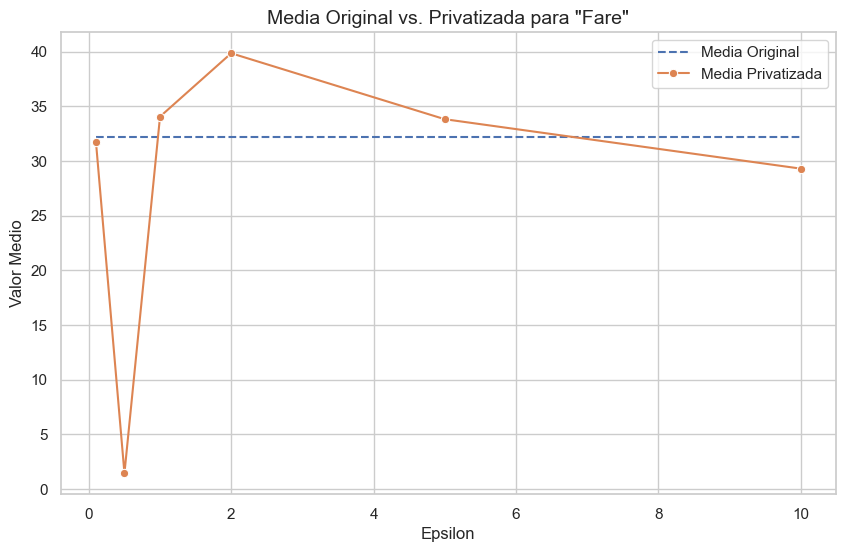

In [7]:
dp_tr.plot_mean_vs_privatized()